In [1]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150
import matplotlib.pyplot as plt
import numpy as np
from pylab import rcParams
import torch.nn.functional as F
import math
import scipy

## Model dimensions

In [2]:
DH = 10.
NX = 600
NY = 350

##  Used functions

In [3]:
FSize = 10
font = {'color':  'black',
        'weight': 'normal',
        'size': FSize}

plt.rc('xtick', labelsize=FSize)
plt.rc('ytick', labelsize=FSize)
rcParams['figure.figsize'] = 14, 12

def plot_mdl(n, model, cm, an, title, vpmin, vpmax, DH, NY):
    ax = plt.subplot(3, 1, n)

    # Convert extent to kilometers by dividing by 1000.
    im = plt.imshow(model, cmap=cm, interpolation='bilinear',
                    extent=[0.0, 520 * DH / 1000, 0.0, NY * DH / 1000],
                    vmin=vpmin, vmax=vpmax)
    plt.axis('scaled')

    # Increase the vertical space between the label and the notation of the x-axis
    ax.xaxis.labelpad = 5  # Adjust this value as needed to increase the space

    if n == 1:  # Assuming you want the x-axis label on the top for the first subplot
        plt.xlabel('y (km)', fontdict=font)
    plt.ylabel('z (km)', fontdict=font)
    
    ax.invert_yaxis()
    
    cbar = plt.colorbar(im, aspect=8, pad=0.02)
    cbar.set_label(title, fontdict=font, labelpad=10)
    plt.text(20. / 1000, 200. / 1000, an, fontdict=font, color='white')  # Update text position to km.

    plt.tight_layout()

def read_model(file_path, NX, NY):
    with open(file_path, "rb") as f:
        data_type = np.dtype("<f4")
        data = np.fromfile(f, dtype=data_type).reshape(NX, NY).T[::-1] #.T[::-1] is to transpose and flip the array
    return data

def bin_count(max_val, min_val, width):
    """Return the number of bins for a histogram
    
    Args:
        max_val (float): The maximum value in the dataset
        min_val (float): The minimum value in the dataset
        width (float): The bin width
    
    Returns:
        int: The number of bins for the histogram
    """
    if width <= 0:
        raise ValueError("Width must be greater than 0")

    return math.ceil((max_val - min_val) / width)

def scotts_rule_count(data):
    """Calculate the number of bins using Scott's rule
    
    Args:
        data (np.ndarray): The data array
    
    Returns:
        int: The number of bins of the histogram
    """
    n = data.shape[0]
    sigma = data.std()
    if sigma == 0 or n == 0:
        raise ValueError("Data variance is zero or empty data")
    width = 3.49 * sigma / n**(1/3)
    return bin_count(data.max(), data.min(), width)


def remove_directional_averages(vp: np.ndarray, *, zero_mean: bool = True):
    """
    Remove the per-row (horizontal) and per-column (vertical) means from a 2-D
    velocity-model array.

    Parameters
    ----------
    vp : ndarray, shape (n_z, n_x)
        2-D array containing P-wave velocity values.  The first axis is depth
        (or time) and the second axis is the lateral/inline direction.
    zero_mean : bool, default True
        If True, the global mean of the residual model is also removed so the
        output has zero overall mean.

    Returns
    -------
    vp_residual : ndarray, shape (n_z, n_x)
        The velocity model after subtracting both horizontal and vertical
        averages.  If *zero_mean* is True, the global mean is also removed.

    vp_hz_avg : ndarray, shape (n_z, 1)
        Column vector containing the horizontal (row-wise) averages that were
        removed.

    vp_vt_avg : ndarray, shape (n_x,)
        Row vector containing the vertical (column-wise) averages that were
        removed.

    Notes
    -----
    Subtracting the two 1-D averages twice (once per direction) introduces a
    constant bias equal to the global mean of *vp*.  Setting *zero_mean=True*
    compensates for that bias so the residual model has mean ≈ 0.

    """
    # Compute horizontal (row-wise) and vertical (column-wise) means
    vp_hz_avg = np.mean(vp, axis=1, keepdims=True)   # (n_z, 1)
    vp_vt_avg = np.mean(vp, axis=0)                  # (n_x,)

    # Create 2-D fields of those means for broadcasting-safe subtraction
    vp_hz_field = np.tile(vp_hz_avg, (1, vp.shape[1]))
    vp_vt_field = np.tile(vp_vt_avg[np.newaxis, :], (vp.shape[0], 1))

    # Remove directional averages
    vp_residual = vp - vp_hz_field - vp_vt_field

    if zero_mean:
        vp_residual -= vp_residual.mean()

    return vp_residual, vp_hz_avg, vp_vt_avg


## Read data

In [4]:
basename = "/wt_test/Kimberlina/model.vp"
name_vp = basename    # Baseline model (smoothed)
vp = read_model(name_vp, NX, NY)
vp = np.flipud(vp)

print("vp min:", vp.min(), "vp max:", vp.max())
print("vp shape:", vp.shape)

vp min: 1975.2448 vp max: 3895.6353
vp shape: (350, 600)


In [5]:
kernel = np.array([[1, 1, 1, 1, 1],
                    [1, 2, 2, 2, 1],
                    [1, 2, 4, 2, 1],
                    [1, 2, 2, 2, 1],
                    [1, 1, 1, 1, 1]], dtype=float)

# Normalize the kernel so that the sum is 1
kernel /= kernel.sum()
slowness = 1 / np.square(vp)
smoothed_slowness = scipy.signal.convolve2d(slowness, kernel, mode='same', boundary='symm')
vp_smth = 1 / np.sqrt(smoothed_slowness)
vp = vp_smth.copy()

In [6]:
vp_removed_avg_zero_mean, vp_hz_avg, vp_vt_avg = remove_directional_averages(vp)
print('Model shape after removing horizontal and vertical averages with zero mean min: ', vp_removed_avg_zero_mean.min(), 'max: ', vp_removed_avg_zero_mean.max())

Model shape after removing horizontal and vertical averages with zero mean min:  -821.8325463238643 max:  904.3833908151378


## Plots

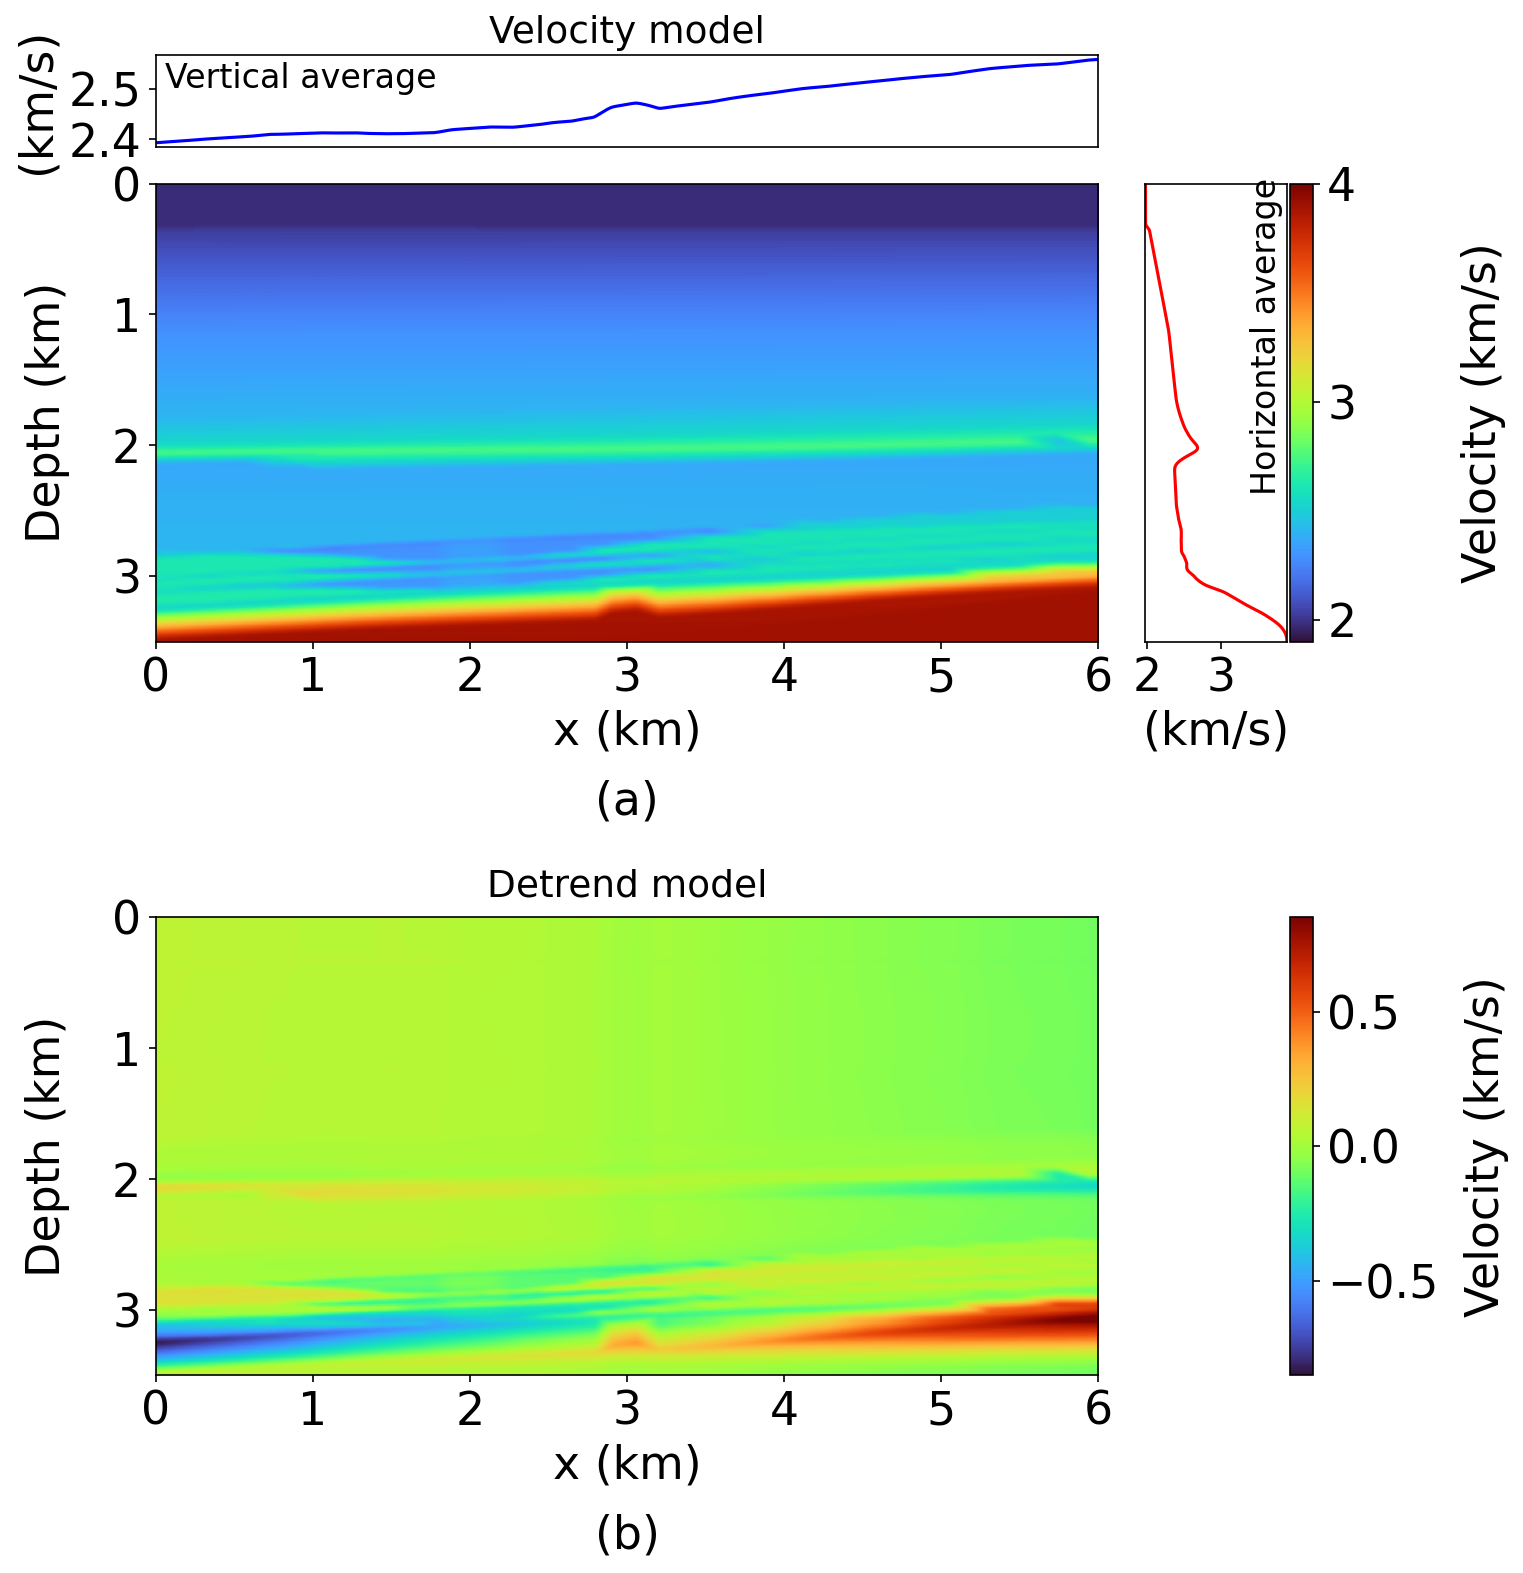

In [7]:
# Create figure and define subplot layout (only using two subplots)
extent = [0.0, 600 * DH / 1000, NY * DH / 1000, 0]  # Set extent for distance and depth in km

fig, ax = plt.subplots(2, 1, figsize=(10, 10), constrained_layout=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.2})

# Main velocity model plot
main_ax = ax[0]
im = main_ax.imshow(vp / 1000, cmap='turbo', aspect='auto', extent=extent, vmin=1.9, vmax=4.0)

# Colorbar for main velocity model
cbar = plt.colorbar(im, ax=main_ax, orientation='vertical', fraction=0.035, pad=0.02)
cbar.ax.tick_params(labelsize=22)
cbar.set_label('Velocity (km/s)', fontsize=22, labelpad=50)

# Labels
main_ax.set_xlabel('x (km)', fontsize=22)
main_ax.set_ylabel('Depth (km)', fontsize=22, labelpad=20)
main_ax.set_title('Velocity model', fontsize=18)
main_ax.tick_params(axis='x', labelsize=22)
main_ax.tick_params(axis='y', labelsize=22)

# Horizontal average plot (right inset)
hz_extent = np.linspace(0, NY * DH / 1000, 350)  # Mapping depth
hz_ax = main_ax.inset_axes([1.05, 0.0, 0.15, 1.0])  # Adjusted position
hz_ax.plot(vp_hz_avg / 1000, hz_extent, color='red')
hz_ax.set_ylim(hz_extent[-1], hz_extent[0])  # Reverse y-axis
hz_ax.set_xlim(vp_hz_avg.min() / 1000, vp_hz_avg.max() / 1000)
hz_ax.yaxis.set_visible(False)
hz_ax.set_xlabel("(km/s)", fontsize=22)
hz_ax.tick_params(axis='x', labelsize=22)

# Explicitly set vertical label
hz_ax.text(
    hz_ax.get_xlim()[0] + 1.65,  # X-position: Adjust left to avoid clipping
    hz_ax.get_ylim()[0] / 3.0,     # Y-position: Centered vertically
    "Horizontal average",        # Label text
    fontsize=16,
    rotation=90,                 # Vertical orientation
    ha="center",                 # Center alignment
    va="center"                  # Center alignment
)


# Vertical average plot (top inset)
vt_extent = np.linspace(0, 600 * DH / 1000, 600)
vt_ax = main_ax.inset_axes([0.0, 1.08, 1.0, 0.2])  # Adjusted position
vt_ax.plot(vt_extent, vp_vt_avg / 1000, color='blue')
vt_ax.set_xlim(vt_extent[0], vt_extent[-1])
vt_ax.xaxis.set_visible(False)
vt_ax.set_ylabel("(km/s)", fontsize=22)
vt_ax.tick_params(axis='y', labelsize=22)

# Explicitly set horizontal label for Vertical Average
vt_ax.text(
    vt_ax.get_xlim()[0] + (vt_ax.get_xlim()[1] - vt_ax.get_xlim()[0]) / 6.5,  # Centered horizontally
    vt_ax.get_ylim()[0] + 0.17,  # Positioned slightly above the plot
    "Vertical average",  # Label text
    fontsize=16,
    ha="center",  # Horizontal alignment centered
    va="top"   # Vertical alignment at the bottom
)


# Model after removing horizontal and vertical averages
im2 = ax[1].imshow(vp_removed_avg_zero_mean / 1000, cmap='turbo', aspect='auto', extent=extent, vmin=-0.85, vmax=0.85)
ax[1].set_title('Detrend model', pad=10, fontsize=18)
ax[1].set_xlabel('x (km)', fontsize=22)
ax[1].set_ylabel('Depth (km)', fontsize=22, labelpad=20)
ax[1].tick_params(axis='x', labelsize=22)
ax[1].tick_params(axis='y', labelsize=22)

# Colorbar for the detrended model (aligned with ax[1])
cbar2 = plt.colorbar(im2, ax=ax[1], orientation='vertical', fraction=0.035, pad=0.02)
cbar2.ax.tick_params(labelsize=22)
cbar2.set_label('Velocity (km/s)', fontsize=22, labelpad=12)

# Add subplot labels
main_ax.text(0.5, -0.35, "(a)", transform=main_ax.transAxes, fontsize=22, 
             ha="center", va="center")

ax[1].text(0.5, -0.35, "(b)", transform=ax[1].transAxes, fontsize=22, 
           ha="center", va="center")

# plt.savefig(f'./plots/Kimb_before_after_removed_1Daverages_zeromean_4paper.png', dpi=300, bbox_inches='tight')
plt.show()


## Model distribution

In [8]:
# Normalize the arrays
vp_normalize= vp / np.max(vp)
vp_removed_avg_zero_mean_normalize = vp_removed_avg_zero_mean * (-1) / np.max(vp_removed_avg_zero_mean * (-1))

# Flatten the arrays to prepare for histogram plotting
vp_normalize_flatten = vp_normalize.flatten()
vp_removed_avg_zero_mean_normalize_flatten = vp_removed_avg_zero_mean_normalize.flatten()

### bin count using Scott's rule
bin_count_scot_vp = scotts_rule_count(vp_normalize_flatten)
bin_count_scot_vp_removed_avg_zero_mean = scotts_rule_count(vp_removed_avg_zero_mean_normalize_flatten)

print("Vp bin_count_vp", bin_count_scot_vp)
print("Vp bin_count_vp after removing 1D averages (zero mean)", bin_count_scot_vp_removed_avg_zero_mean)

Vp bin_count_vp 70
Vp bin_count_vp after removing 1D averages (zero mean) 218


/var/folders/fn/00dnr6qs51dbrf8b57ns7r8r0000gn/T/ipykernel_38054/3086898522.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.0f}'.format(y / 100) for y in yticks])
/var/folders/fn/00dnr6qs51dbrf8b57ns7r8r0000gn/T/ipykernel_38054/3086898522.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.0f}'.format(y / 100) for y in yticks])


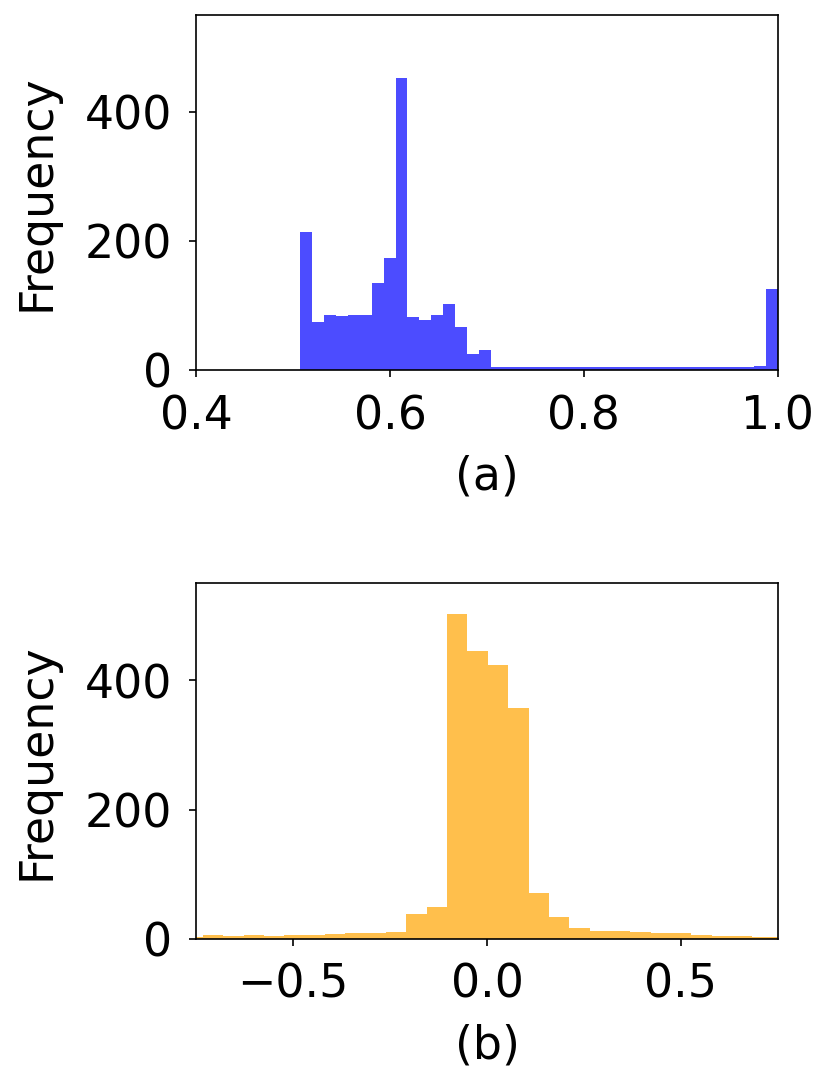

In [9]:
common_bin_count = max(bin_count_scot_vp, bin_count_scot_vp_removed_avg_zero_mean)

# Create histograms for each parameter
fig, axes = plt.subplots(2, 1, figsize=(5, 8))

axes[0].hist(vp_normalize_flatten, bins=40, color='blue', alpha=0.7)
axes[0].set_xlim([0.4, 1])
axes[0].set_ylim([0, 55000])
axes[0].set_ylabel('Frequency')

axes[1].hist(vp_removed_avg_zero_mean_normalize_flatten, bins=40, color='orange', alpha=0.7)
# axes[1].set_title(r'$V_{\mathrm{p}}$ (detrend model)')
axes[1].set_xlim([-0.75, 0.75])
axes[1].set_ylim([0, 55000])
axes[1].set_ylabel('Frequency')


for ax in axes.flat:
    ax.set_title(ax.get_title(), fontsize=18, pad=15)
    ax.set_xlabel(ax.get_xlabel(), fontsize=22)
    ax.set_ylabel(ax.get_ylabel(), fontsize=22, labelpad=12)
    ax.tick_params(axis='both', labelsize=22, pad=8)
    yticks = ax.get_yticks()
    ax.set_yticklabels(['{:.0f}'.format(y / 100) for y in yticks])


axes[0].text(0.5, -0.3, "(a)", transform=axes[0].transAxes, fontsize=22, 
             ha="center", va="center")

axes[1].text(0.5, -0.3, "(b)", transform=axes[1].transAxes, fontsize=22, 
             ha="center", va="center")

fig.subplots_adjust(hspace=0.6, wspace=0.3)
# plt.savefig(f'./plots/histogram_KimModelVp_removing_1D_averages_with_zeromean_vertical_plot_4paper_withoutTitles.png', dpi=300, bbox_inches='tight')
plt.show()